 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For preprocessing
from sklearn.compose import ColumnTransformer # For applying different transformers to different columns
from sklearn.pipeline import Pipeline # To chain steps
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
print("Libraries imported.")

Libraries imported.


 Load and Initial Prep (Stroke Dataset)

In [4]:
file_path = '../data/healthcare-dataset-stroke-data.csv'
try:
    stroke_df = pd.read_csv(file_path)
    print("Stroke dataset loaded successfully.")
    display(stroke_df.head())
    stroke_df.info()
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    stroke_df = None

if stroke_df is not None:
    # Basic Cleaning (similar to EDA)
    # Drop 'id' as it's an identifier
    if 'id' in stroke_df.columns:
        stroke_df.drop('id', axis=1, inplace=True)

    # Handle 'Other' gender if present (e.g., by dropping)
    if 'gender' in stroke_df.columns and 'Other' in stroke_df['gender'].unique():
        stroke_df = stroke_df[stroke_df['gender'] != 'Other']
    
    # Impute 'bmi' with median
    if 'bmi' in stroke_df.columns:
       stroke_df['bmi'] = stroke_df['bmi'].fillna(stroke_df['bmi'].median())

    print("\nDataset after initial cleaning and BMI imputation:")
    print(f"Missing values sum:\n{stroke_df.isnull().sum().sum()}") # Should be 0
    display(stroke_df.head())

Stroke dataset loaded successfully.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Dataset after initial cleaning and BMI imputation:
Missing values sum:
0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Define Features (X) and Target (y), Preprocessing Pipeline

Logistic regression, like many other algorithms, requires categorical features to be converted to numeric (e.g., One-Hot Encoding) and numerical features to be scaled.

In [ ]:
if stroke_df is not None:
    X = stroke_df.drop('stroke', axis=1)
    y = stroke_df['stroke']

    # Identify categorical and numerical features
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns

    print(f"Categorical features: {list(categorical_features)}")
    print(f"Numerical features: {list(numerical_features)}")

    # Create preprocessing pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' to avoid multicollinearity
    ])

    # Create a ColumnTransformer to apply pipelines to respective columns
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

Categorical features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']


Split Data

In [6]:
if 'X' in locals():
    # Split data (before applying the preprocessor, it will be fit on train and transform both)
    # stratify=y is important for imbalanced datasets to keep class proportions similar in train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

X_train shape: (4087, 10)
X_test shape: (1022, 10)


 Create and Train Logistic Regression Model (within a full pipeline)

In [7]:
if 'preprocessor' in locals():
    # Create the full pipeline: preprocessor + logistic regression model
    log_reg_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')) 
        # solver='liblinear' is good for smaller datasets.
        # class_weight='balanced' helps with imbalanced target variable like 'stroke'
    ])

    # Train the pipeline
    log_reg_pipeline.fit(X_train, y_train)
    print("Logistic Regression pipeline trained successfully.")

Logistic Regression pipeline trained successfully.


Make Predictions and Evaluate


Accuracy: 0.7378

Confusion Matrix:


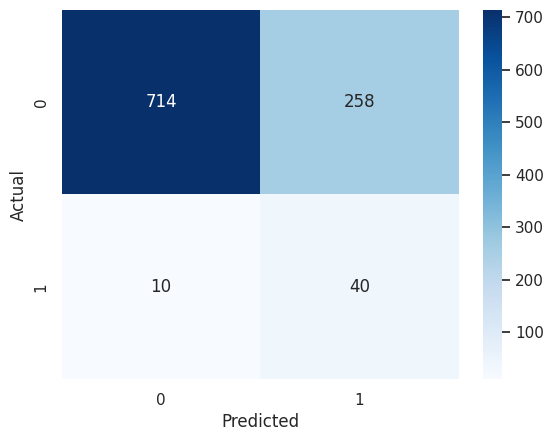


Classification Report:
               precision    recall  f1-score   support

No Stroke (0)       0.99      0.73      0.84       972
   Stroke (1)       0.13      0.80      0.23        50

     accuracy                           0.74      1022
    macro avg       0.56      0.77      0.54      1022
 weighted avg       0.94      0.74      0.81      1022


ROC AUC Score: 0.8390


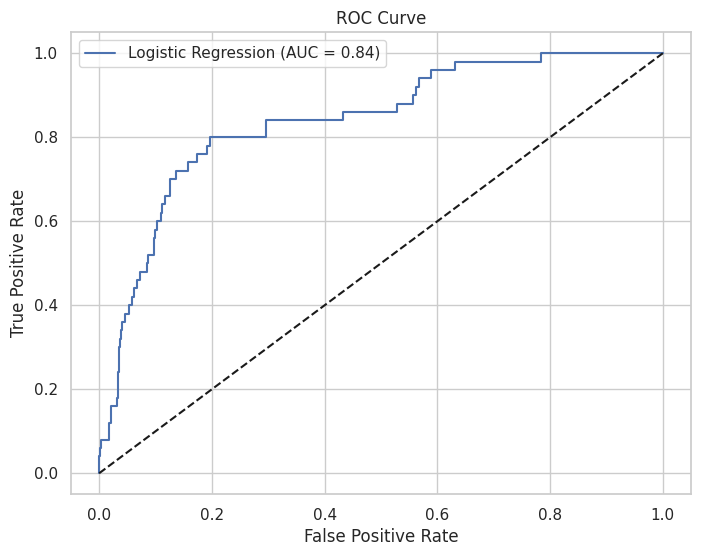

In [8]:
if 'log_reg_pipeline' in locals():
    y_pred = log_reg_pipeline.predict(X_test)
    y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class (stroke=1)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Stroke (0)', 'Stroke (1)']))

    # ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guessing line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()